# Evaluate Token-level MLM Results

***

## Set Up Analysis

In [47]:
import csv
import pandas as pd
import os
import re
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import matplotlib.font_manager as font_manager
import string

import numpy as np

### Load Test Sets

In [2]:
%%time

test_set_dict = {}

directory = '../../0_data/clean/unlabelled_reddit/error_analysis'
for filename in sorted(os.listdir(directory)):
    if filename.endswith("_5k.csv"):
        print(f"reading {filename}")
        test_set_dict[filename.lstrip("pol_").rstrip(".csv")] = pd.read_csv(os.path.join(directory, filename),
                                                                            converters={"text_ner": literal_eval, 'text_pos': literal_eval,
                                                                                        'text_ner': literal_eval, 'text_tokens': literal_eval,
                                                                                        'tokens_pos': literal_eval, 'tokens_ner': literal_eval})

reading pol_test_2017_03_5k.csv
reading pol_test_2017_04_5k.csv
reading pol_test_2017_05_5k.csv
reading pol_test_2017_06_5k.csv
reading pol_test_2017_07_5k.csv
reading pol_test_2017_08_5k.csv
reading pol_test_2017_09_5k.csv
reading pol_test_2017_10_5k.csv
reading pol_test_2017_11_5k.csv
reading pol_test_2017_12_5k.csv
reading pol_test_2018_01_5k.csv
reading pol_test_2018_02_5k.csv
reading pol_test_2018_03_5k.csv
reading pol_test_2018_04_5k.csv
reading pol_test_2018_05_5k.csv
reading pol_test_2018_06_5k.csv
reading pol_test_2018_07_5k.csv
reading pol_test_2018_08_5k.csv
reading pol_test_2018_09_5k.csv
reading pol_test_2018_10_5k.csv
reading pol_test_2018_11_5k.csv
reading pol_test_2018_12_5k.csv
reading pol_test_2019_01_5k.csv
reading pol_test_2019_02_5k.csv
reading pol_test_2019_03_5k.csv
reading pol_test_2019_04_5k.csv
reading pol_test_2019_05_5k.csv
reading pol_test_2019_06_5k.csv
reading pol_test_2019_07_5k.csv
reading pol_test_2019_08_5k.csv
reading pol_test_2019_09_5k.csv
reading 

### Load Token-Level MLM Results

In [3]:
%%time

mlm_results_dict = {}

directory = '../../0_results/mlm/reddit/token-test/max_seq_128'
for filename in sorted(os.listdir(directory)):
    if filename.endswith("_5k.csv"):
        mlm_results_dict[filename.rstrip(".csv")] = pd.read_csv(os.path.join(directory, filename))

CPU times: user 7.04 s, sys: 1.7 s, total: 8.74 s
Wall time: 15.7 s


### Merge Token-Level MLM Results to Test Sets

In [4]:
full_df_dict = {}

def masked_token_pos(row):
    return row.tokens_pos[row.masked_token_array_id][1]

def masked_token_ner(row):
    return row.tokens_ner[row.masked_token_array_id][1]

def masked_token_ner_binary(row):
    if row.tokens_ner[row.masked_token_array_id][1] != "NO_ENT":
        return "ENT"
    else:
        return "NO_ENT"

# merge info on masked tokens to test_sets
for test_set in test_set_dict:
    print('processing', test_set)
    full_df_dict[test_set] = test_set_dict[test_set].merge(mlm_results_dict[f"bert-base-{test_set}"], how="inner", left_index=True, right_on="case_id")
    full_df_dict[test_set].drop(columns=["ce_loss", "pred_logits", "top_pred_token_vocab_id", "top_pred_token_text"], inplace=True)
    
    full_df_dict[test_set]["masked_token_pos"]=full_df_dict[test_set].apply(lambda x: masked_token_pos(x), axis=1)
    full_df_dict[test_set]["masked_token_ner"]=full_df_dict[test_set].apply(lambda x: masked_token_ner(x), axis=1)
    full_df_dict[test_set]["masked_token_ner_binary"]=full_df_dict[test_set].apply(lambda x: masked_token_ner_binary(x), axis=1)

processing test_2017_03_5k
processing test_2017_04_5k
processing test_2017_05_5k
processing test_2017_06_5k
processing test_2017_07_5k
processing test_2017_08_5k
processing test_2017_09_5k
processing test_2017_10_5k
processing test_2017_11_5k
processing test_2017_12_5k
processing test_2018_01_5k
processing test_2018_02_5k
processing test_2018_03_5k
processing test_2018_04_5k
processing test_2018_05_5k
processing test_2018_06_5k
processing test_2018_07_5k
processing test_2018_08_5k
processing test_2018_09_5k
processing test_2018_10_5k
processing test_2018_11_5k
processing test_2018_12_5k
processing test_2019_01_5k
processing test_2019_02_5k
processing test_2019_03_5k
processing test_2019_04_5k
processing test_2019_05_5k
processing test_2019_06_5k
processing test_2019_07_5k
processing test_2019_08_5k
processing test_2019_09_5k
processing test_2019_10_5k
processing test_2019_11_5k
processing test_2019_12_5k
processing test_2020_01_5k
processing test_2020_02_5k


In [5]:
# merge model ce_losses
for test_set in full_df_dict:
    n_rows = full_df_dict[test_set].shape[0]
    for result in sorted(mlm_results_dict):
        if test_set in result:
            if mlm_results_dict[result].shape[0] == n_rows:
                if ("base" in result) or ("rand_1m" in result):
                    full_df_dict[test_set] = full_df_dict[test_set].merge(mlm_results_dict[result]["ce_loss"].rename("ce_{}".format(re.search("bert-(.*?)-test(.*?)",result).group(1))),
                                                                              how="inner", left_index=True, right_index=True)
                else:
                    full_df_dict[test_set] = full_df_dict[test_set].merge(mlm_results_dict[result]["ce_loss"].rename("ce_match_1m"),
                                                          how="inner", left_index=True, right_index=True)
            else: 
                print(f"{result} results do not match number of rows in test set")

In [6]:
# clear up RAM
del mlm_results_dict
del test_set_dict

***

# MAIN ANALYSIS

### Concatenate monthly results into single dataframe

In [287]:
for key in full_df_dict:
    full_df_dict[key]["source"] = key

overall_df = pd.concat(full_df_dict.values(), ignore_index=True)

### Clean POS errors in small classes


In [288]:
valid_pos={}

valid_pos["PART"]=["to", "'", "not", "s", "’"]
valid_pos["PUNCT"] = list(string.punctuation + "’" + "“"+ "”" + "‘" + "—")
valid_pos["CCONJ"] = ['and', 'but', 'or', '&', 'either', 'so', 'nor', 'both', 'plus', 'yet', 'neither']

for pos in valid_pos:
    mask = (overall_df.masked_token_pos == pos)&(overall_df.masked_token_text.apply(lambda x: x not in valid_pos[pos]))
    print(f"dropping {mask.sum()} invalid {pos} tokens")
    overall_df = overall_df[~mask]

dropping 16 invalid PART tokens
dropping 1289 invalid PUNCT tokens
dropping 99 invalid CCONJ tokens


### BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

In [289]:
# BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

# first column is number of tokens by POS tag
calc_df = pd.DataFrame(overall_df.groupby("masked_token_pos").tokens_pos.count()).merge(overall_df.groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)

# merge rand adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)

# merge match adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_match_1m.sum(), left_index=True, right_index=True)

calc_df = calc_df.sort_values("tokens_pos", ascending=False)

calc_df["diff_base_rand_sum"] = calc_df.iloc[:,1]-calc_df.iloc[:,2]
calc_df["diff_base_rand_mean"] = calc_df["diff_base_rand_sum"]/calc_df["tokens_pos"]
calc_df["diff_base_rand_pct"] = (calc_df.iloc[:,1]-calc_df.iloc[:,2])/calc_df.iloc[:,1]
calc_df = calc_df[["tokens_pos", "diff_base_rand_sum", "diff_base_rand_mean", "diff_base_rand_pct"]]

# drop rare unknown and symbol tokens
calc_df.drop(["X", "SYM"], inplace=True)


display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

,tokens_pos,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_pos,,,,
NOUN,185436,227276.01,1.23,0.28
VERB,141077,178069.61,1.26,0.33
PUNCT,116698,118238.60,1.01,0.54
PRON,86932,51395.14,0.59,0.31
DET,83225,35248.90,0.42,0.27
ADP,76139,36029.35,0.47,0.26
ADJ,71408,75059.50,1.05,0.24
ADV,57817,57781.95,1.00,0.26
AUX,56866,54384.74,0.96,0.51


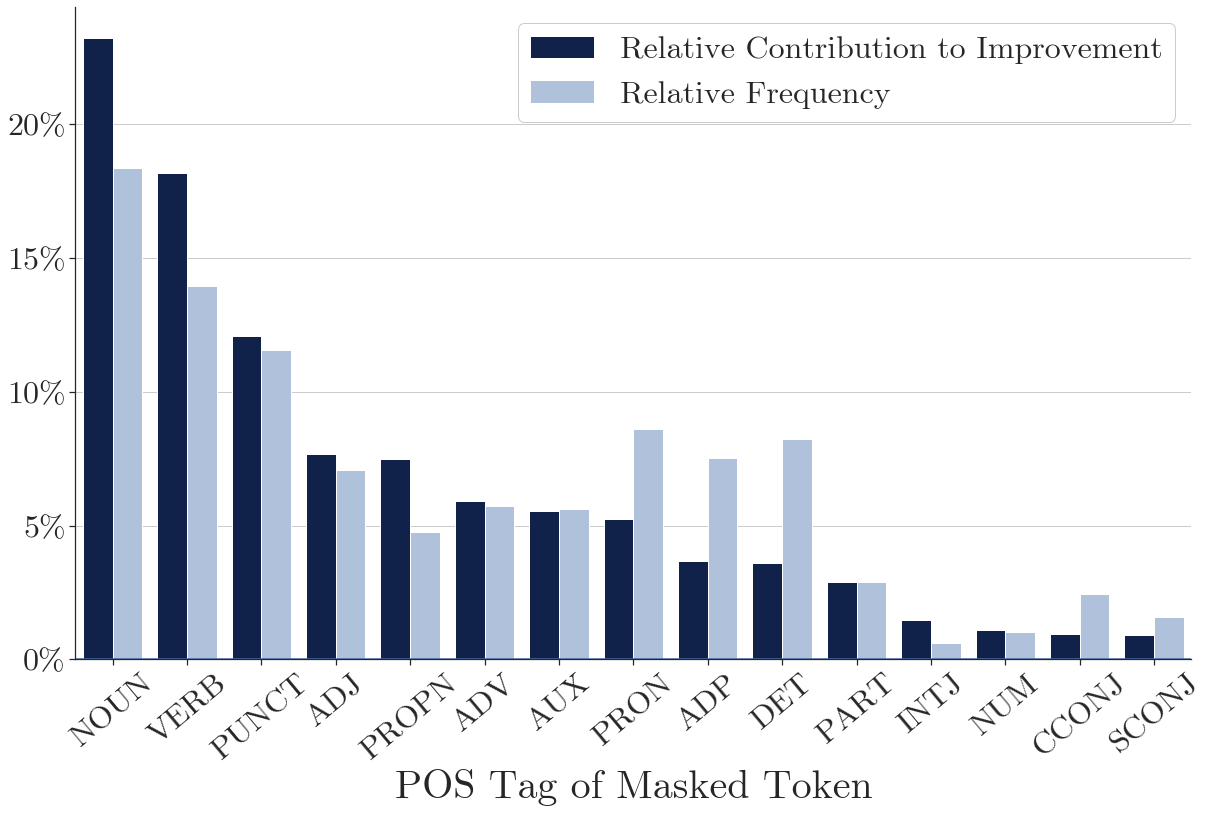

In [290]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False


calc_df["prop_token"] = calc_df.iloc[:,0]/calc_df.iloc[:,0].sum()
calc_df["prop_improvement"] = calc_df.iloc[:,1]/calc_df.iloc[:,1].sum()
tidy_df = calc_df[["prop_improvement", "prop_token"]].sort_values("prop_improvement", ascending=False).reset_index().melt(id_vars="masked_token_pos").rename(columns=str.title)

fig, ax = plt.subplots(figsize=(20, 12))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))

# create seaborn plot
colors = ["#071e54", "#a8c0e2"]
ax=sns.barplot(x='Masked_Token_Pos', y='Value', hue='Variable', data=tidy_df, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='POS Tag of Masked Token', ylabel='')

# configure legend
legend = ax.legend(framealpha=1,  prop={'size': 32})
legend.get_texts()[0].set_text("Relative Contribution to Improvement")
legend.get_texts()[1].set_text("Relative Frequency")

# set font sizes
ax.xaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

sns.despine(fig)

ax.axhline()

plt.xticks(rotation = 40)

plt.show()

### RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

In [232]:
# RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

# first column is number of tokens by POS tag
calc_df = pd.DataFrame(overall_df.groupby("masked_token_pos").tokens_pos.count()).merge(overall_df.groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)

# merge rand adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)

# merge match adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_match_1m.sum(), left_index=True, right_index=True)

calc_df = calc_df.sort_values("tokens_pos", ascending=False)

calc_df["diff_rand_match_sum"] = calc_df.iloc[:,2]-calc_df.iloc[:,3]
calc_df["diff_rand_match_mean"] = calc_df["diff_rand_match_sum"]/calc_df["tokens_pos"]
calc_df["diff_rand_match_pct"] = (calc_df.iloc[:,2]-calc_df.iloc[:,3])/calc_df.iloc[:,2]
calc_df = calc_df[["tokens_pos", "diff_rand_match_sum", "diff_rand_match_mean", "diff_rand_match_pct"]]

# drop rare unknown and symbol tokens
calc_df.drop(["X", "SYM"], inplace=True)

display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

,tokens_pos,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_pos,,,,
NOUN,185436,2367.25,0.01,0.00
VERB,141077,1102.50,0.01,0.00
PUNCT,116698,-251.23,-0.00,-0.00
PRON,86932,136.86,0.00,0.00
DET,83225,772.27,0.01,0.01
ADP,76139,137.38,0.00,0.00
ADJ,71408,115.33,0.00,0.00
ADV,57817,418.21,0.01,0.00
AUX,56866,362.43,0.01,0.01


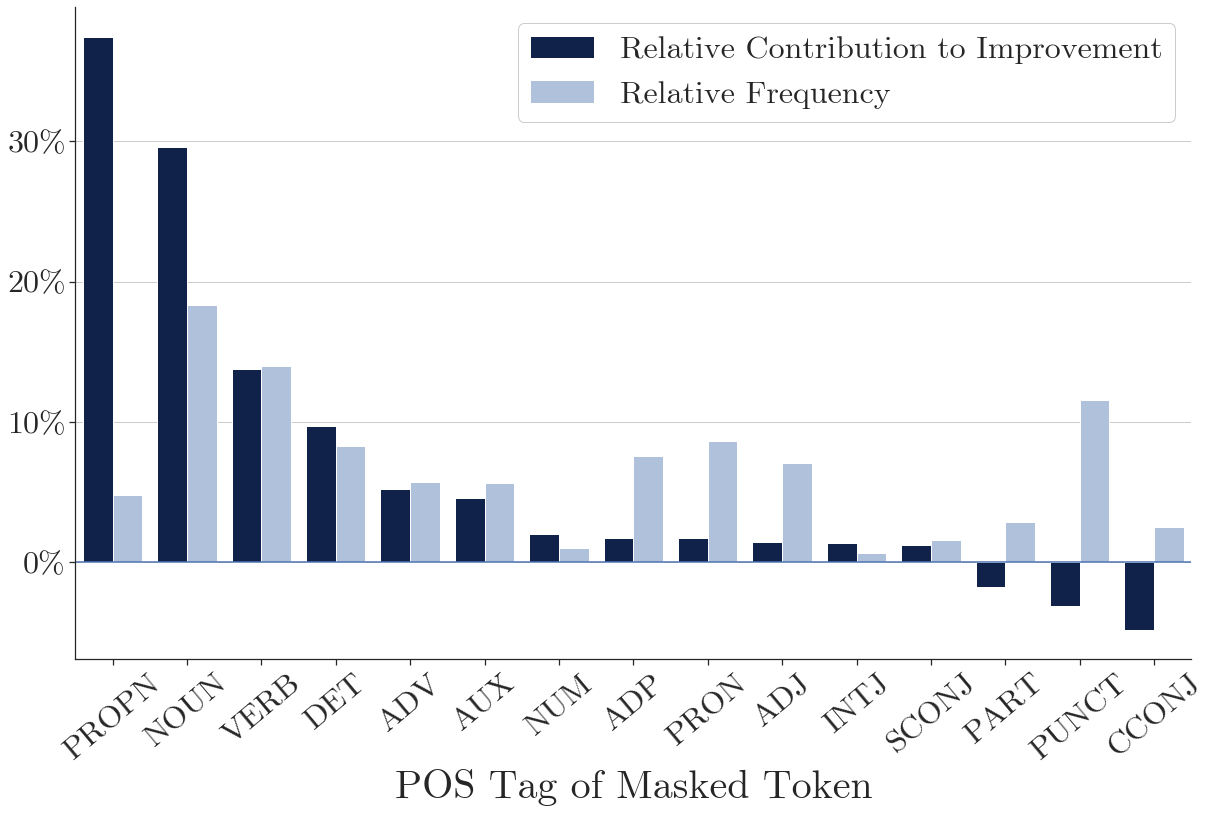

In [252]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False


calc_df["prop_token"] = calc_df.iloc[:,0]/calc_df.iloc[:,0].sum()
calc_df["prop_improvement"] = calc_df.iloc[:,1]/calc_df.iloc[:,1].sum()
tidy_df = calc_df[["prop_improvement", "prop_token"]].sort_values("prop_improvement", ascending=False).reset_index().melt(id_vars="masked_token_pos").rename(columns=str.title)

fig, ax = plt.subplots(figsize=(20, 12))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))

# create seaborn plot
colors = ["#071e54", "#a8c0e2"]
ax=sns.barplot(x='Masked_Token_Pos', y='Value', hue='Variable', data=tidy_df, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='POS Tag of Masked Token', ylabel='')

# configure legend
legend = ax.legend(framealpha=1,  prop={'size': 32})
legend.get_texts()[0].set_text("Relative Contribution to Improvement")
legend.get_texts()[1].set_text("Relative Frequency")

# set font sizes
ax.xaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

sns.despine(fig)

ax.axhline()

plt.xticks(rotation = 40)

plt.show()

In [150]:
# number of masked tokens:
overall_df.shape[0]

1013758

### What is the distribution of improvements across PROPNs?

In [291]:
%%time

top_df = overall_df[overall_df.masked_token_pos=="PROPN"][["case_id", "text", "masked_token_text", "ce_base", "ce_rand_1m", "ce_match_1m", "source"]].copy()
top_df["ce_diff_rand_match"] = top_df.ce_rand_1m - top_df.ce_match_1m
top_df["ce_diff_base_rand"] = top_df.ce_base - top_df.ce_rand_1m
top_df["ce_diff_base_match"] = top_df.ce_base - top_df.ce_match_1m

bins = []
sums = []

for inc in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    subset_improvement = top_df.ce_diff_rand_match.sort_values(ascending=False)[int(top_df.shape[0]*(inc-0.1)):int(top_df.shape[0]*inc)].sum()
    overall_improvement = top_df.ce_diff_rand_match.sum()
    bins.append(int(inc*10))
    sums.append(subset_improvement/overall_improvement)

CPU times: user 651 ms, sys: 4.56 s, total: 5.21 s
Wall time: 9.39 s


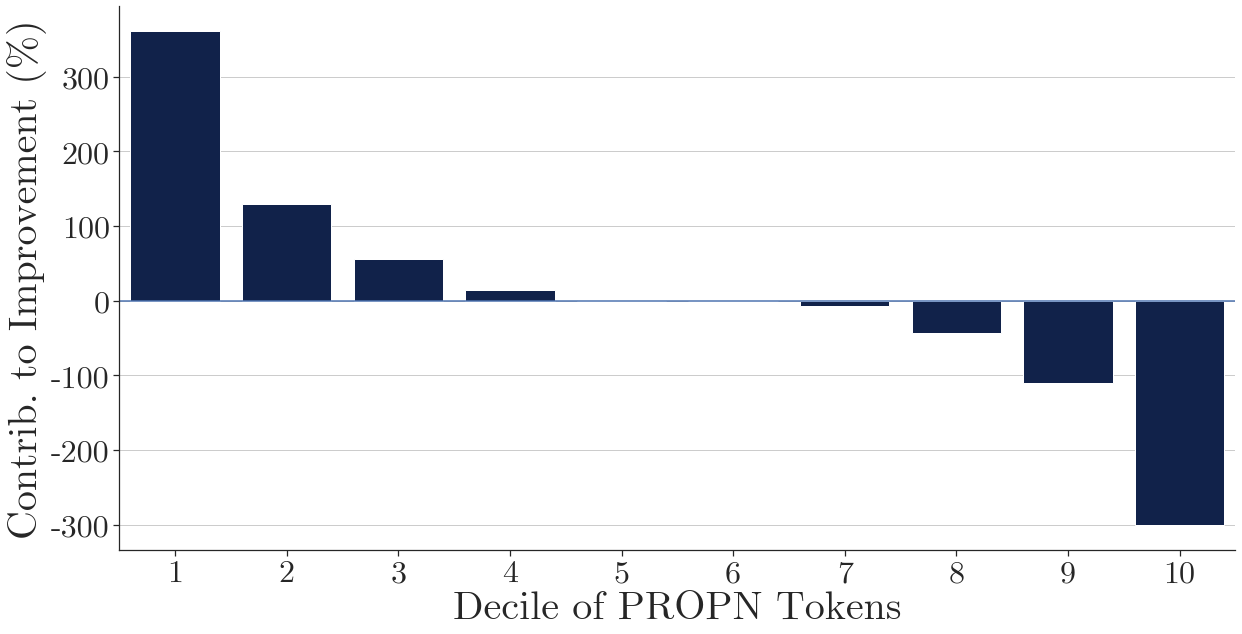

In [292]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(20, 10))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0, symbol=""))

# create seaborn plot
colors = ["#071e54"]
ax=sns.barplot(x=bins, y=sums, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='Decile of PROPN Tokens', ylabel='Contrib. to Improvement (%)')

# set font sizes
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

ax.axhline()

sns.despine(fig)

plt.show()

In [293]:
top_df.shape[0]

48107

### Which proper nouns had large improvements through temporal adaptation?

In [303]:
top_df[top_df.masked_token_text=="c"]

,case_id,text,masked_token_text,ce_base,ce_rand_1m,ce_match_1m,source,ce_diff_rand_match,ce_diff_base_rand,ce_diff_base_match
37341,1172,Have you ever seen a Republican from Texas? I ...,c,2.890956,3.281487,2.954764,test_2017_04_5k,0.326723,-0.390531,-0.063808
41026,1786,1 cup of C4,c,0.975588,1.836889,1.396933,test_2017_04_5k,0.439956,-0.861300,-0.421345
76901,2694,Capitalism by Anwar Shaikh What Every Environm...,c,5.989722,7.704124,5.951851,test_2017_05_5k,1.752273,-1.714402,0.037871
215366,584,E V I D E N C E / V / V / I / I / D / D E V I ...,c,2.446407,3.771284,3.516530,test_2017_10_5k,0.254754,-1.324877,-1.070123
234727,3797,I'm convinced that The shooter was a far right...,c,0.388034,1.153717,0.064290,test_2017_10_5k,1.089426,-0.765683,0.323744
283954,2086,I'd suggest required reading for every thinkin...,c,11.578865,11.720271,10.235268,test_2017_12_5k,1.485003,-0.141406,1.343597
361788,424,How could the Bolsheviks armed with nothing po...,c,0.012080,0.030860,0.361459,test_2018_03_5k,-0.330598,-0.018780,-0.349379
390836,474,"Yeah, she's a straight up PAWG now. Think Nick...",c,7.401464,7.874660,7.034297,test_2018_04_5k,0.840363,-0.473196,0.367167
432761,2628,simultaneously creating a lot of poisonous res...,c,0.004141,0.000465,0.001362,test_2018_05_5k,-0.000897,0.003676,0.002779
517489,2730,We had a large transport craft (looked like a ...,c,0.650127,1.955902,2.470442,test_2018_08_5k,-0.514540,-1.305775,-1.820315


In [295]:
## display top 10

out_df = top_df[top_df.ce_rand_1m<top_df.ce_base].sort_values("ce_diff_rand_match", ascending=False).head(10)

pd.set_option('display.max_colwidth', None)
#display(out_df)
pd.reset_option('display.max_colwidth')

,case_id,text,masked_token_text,ce_base,ce_rand_1m,ce_match_1m,source,ce_diff_rand_match,ce_diff_base_rand,ce_diff_base_match
1001613,2390,What is Newsom's plan if 2019-nCov escapes quarantine? Or is that his plan for the homeless?,nc,14.097670,11.923356,0.001382,test_2020_02_5k,11.921974,2.174314,14.096287
383247,4092,"I'm actually shocked that Trump didn't fire Tillerson after the moron comment. I said it somewhere else, but I'm pretty convinced that Trump is addicted to firing people, and couldn't let go of that mindset from reality show to White House.",##erson,13.570045,11.193896,0.000115,test_2018_03_5k,11.193781,2.376148,13.569930
310205,1552,"we can still say that we expected better from Aziz Ansari It's none of your business, that's my opinion.",aziz,17.461544,10.650843,0.079531,test_2018_01_5k,10.571312,6.810701,17.382013
721673,267,"In a related story, gun possession charges have been filed against the security guard by Kim Foxx.",kim,11.265576,10.409239,0.404922,test_2019_04_5k,10.004317,0.856338,10.860655
914700,1079,"Guys, you're not getting the point. Female trans/genderfluid/non-binary PoCs are the backbone of our democracy (pretty much the EXACT Warren quote). We must give them their proper representation in government.. And you're all misogynistic if you hate this idea. REEEEEEEEEEEEEE",warren,14.126513,10.785352,1.243608,test_2019_11_5k,9.541744,3.341162,12.882905
834947,1371,"McConnell has embraced the ""Grim Reaper"" label. He tells his supporters he's proud to kill ""liberal, socialist policies"" presented by Democrats. ""Moscow Mitch,"" on the other hand, he seemingly despises.",moscow,12.887622,9.687475,0.649284,test_2019_08_5k,9.038191,3.200147,12.238338
355583,4358,"When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like lobertarians, instead of having good ideas and being able to get teh sex. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Drumfpsterdoodles, instead of having good ideas and being able to get in the White House. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Tide pod eaters, instead of having good ideas and being able to get into the washing machine. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Velociraptors Opening Doors, instead of having good ideas and being able to get into the control room ah ah ahhh, ah ah ahhh, ah ah ahhh. Spared no expense! When you realize there are people with su",tide,9.700526,8.788287,0.026859,test_2018_02_5k,8.761428,0.912239,9.673668
180600,4733,"How does the women's march fit into this whole thing? As far as I can tell libs were behind it 100%. What were the differences between it and Cville? Are libs really beating up on Antifa that much? I can't really figure out which way is up anymore in the media landscape so I'm not quite sure if Chapo is calling out a large trend or just some fringe assholes. Also, my (admittedly thin) knowledge of the civil rights era and protests understands the non-violence/turn the other cheek approach that MLK pursued to be far and away the most effective method of protest in US history. Is that an accurate characterization of that time, and if so, should we push for public action more along those lines instead of the more militant style of Antifa? I'm afraid fights of completely legitimate self defense will nonetheless get processed by 1/2 the country as aggression. Bodily self sacrifice is much harder to spin though I think. Welcome any correction/criticism of this, just trying to work things out in my head.",cv,11.515744,11.293634,2.783820,test_2017_08_5k,8.509815,0.222110,8.731925
442483,4288,"How can a neo\-Nazi slogan pre\-date the original Nazism? W

In [302]:
# write top 10% tokens and test_month to pickle
export_df = top_df.sort_values("ce_diff_rand_match", ascending=False)[["masked_token_text", "source", "ce_diff_rand_match", "ce_base", "ce_rand_1m", "ce_match_1m"]]
export_df.to_csv("../../0_data/clean/labelled_reddit/error_analysis/most_improved_propn.csv", index=False)


#export_df = top_df[top_df.ce_rand_1m<top_df.ce_base].sort_values("ce_diff_rand_match", ascending=False).head(int(0.1*top_df[top_df.ce_rand_1m<top_df.ce_base].shape[0]))

In [191]:
# tokens with least change in CE loss: TADA vs DADA

pd.set_option('display.max_colwidth', None)
display(top_df.iloc[top_df['ce_diff_rand_match'].abs().argsort()].head(5))
pd.reset_option('display.max_colwidth')

,case_id,text,masked_token_text,ce_base,ce_rand_1m,ce_match_1m,ce_diff_rand_match
256580,2532,Seriously. Breitbart was a dark time for conservative media (back when Andrew Breitbart was alive). They were basically the only bottom feeders left standing.,br,8.344654e-07,7.152560e-07,7.152560e-07,0.000000e+00
509958,1391,Coulda sworn I read somewhere Erdogan is like a possible mossad agent. And I wouldn't be surprised tbh...,##dog,4.020654e-01,1.072884e-06,1.072884e-06,0.000000e+00
450904,791,Here's a sneak peek of /r/Kremlin using the [top posts]([URL] of the year! \#1: [NATO: Russia's nuclear threats are unacceptable]([URL] | [1 comment]([URL] \#2: [New memo suggests Russian lawyer at Trump Tower meeting was acting 'as an agent' of the Kremlin]([URL] | [0 comments]([URL] \#3: [A Russian political exile who warned he was on Putin's hitlist has been found dead in London]([URL] | [1 comment]([URL],##lin,1.049950e-03,1.072889e-05,1.072889e-05,0.000000e+00
891407,1792,"Erdogan beat Trump who decided to not listen to his military and intelligence officers or plan for different scenarios. When we decided to partner with the SDF (after Erdogan refused to take steps to stop ISIS) we knew it would be tricky and we would have to push on but also reassure our NATO ally that we wouldn’t let the Kurds encroach into turkey. So Erdogan convinced trump to take down defenses to provide a showing of a more stable safety zone. Then he told Trump two weeks later that he was rolling in, like it or not. Trump was outmaneuvered and he folded. He didn’t know how he was going to react beforehand on a very obvious scenario. And it’s going to cost the lives of the people that shed blood with us and is going to cost them their peoples homes when they are driven out and replaced with Syrian refugees now in turkey (turkey has pledged 30B for it). It also hands syria to Iran and Russia, forces our gulf allies to reestablish relations with Assad, and gives Iran a good chance at establishing ent",##dog,1.907350e-06,-0.000000e+00,1.192093e-07,-1.192093e-07
864349,1830,"**FOR THE LOVE OF GOD GET THIS PATRIOT A BRICK! THAT'S 153716 BRICKS HANDED OUT!** We are at **21.6506990886748548445164928%** of our goal to **BUILD THE WALL** starting from Imperial Beach, CA to Brownsville, Texas! Let's make sure everyone gets a brick in the United States! For every Centipede a brick, for every brick a Centipede! At this rate, the wall will be **1690.26788478132822097886992 MILES WIDE** and **450.471504557992128017460852 FEET HIGH** by tomorrow! **DO YOUR PART!**",##ipe,-0.000000e+00,1.192093e-07,2.384186e-07,-1.192093e-07


In [195]:
full_df_dict["test_2020_01_5k"][full_df_dict["test_2020_01_5k"].masked_token_text=="iran"]

,text,text_pos,text_ner,text_tokens,tokens_pos,tokens_ner,case_id,masked_token_array_id,masked_token_vocab_id,masked_token_text,top_pred_token_vocab_id,top_pred_token_text,masked_token_pos,masked_token_ner,masked_token_ner_binary,ce_match_1m,ce_base,ce_rand_1m
3354,"Didn't ""copy and paste"" it from another reddit...","[[Didn, PROPN], [', PART], [t, NOUN], ["", PUNC...","[[Didn, NO_ENT, O], [', NO_ENT, O], [t, NO_ENT...","[[CLS], didn, ', t, "", copy, and, paste, "", it...","[[[CLS], SPECIAL], [didn, PROPN], [', PART], [...","[[[CLS], SPECIAL], [didn, NO_ENT], [', NO_ENT]...",607,104,4238,iran,4238,iran,PROPN,GPE,ENT,0.000026,0.000108,0.000198
7303,Not a conspiracy at all if the photos I've see...,"[[Not, PART], [a, DET], [conspiracy, NOUN], [a...","[[Not, NO_ENT, O], [a, NO_ENT, O], [conspiracy...","[[CLS], not, a, conspiracy, at, all, if, the, ...","[[[CLS], SPECIAL], [not, PART], [a, DET], [con...","[[[CLS], SPECIAL], [not, NO_ENT], [a, NO_ENT],...",1332,77,4238,iran,4238,iran,PROPN,GPE,ENT,0.060255,0.035846,0.057071
8006,"Hard to say. 3 years they screamed ""Russian"" a...","[[Hard, ADJ], [to, PART], [say, VERB], [., PUN...","[[Hard, NO_ENT, O], [to, NO_ENT, O], [say, NO_...","[[CLS], hard, to, say, ., 3, years, they, scre...","[[[CLS], SPECIAL], [hard, ADJ], [to, PART], [s...","[[[CLS], SPECIAL], [hard, NO_ENT], [to, NO_ENT...",1458,49,4238,iran,1012,.,PROPN,GPE,ENT,3.175887,8.750072,3.964158
10480,Regardless what you think of the money given b...,"[[Regardless, ADV], [what, PRON], [you, PRON],...","[[Regardless, NO_ENT, O], [what, NO_ENT, O], [...","[[CLS], regardless, what, you, think, of, the,...","[[[CLS], SPECIAL], [regardless, ADV], [what, P...","[[[CLS], SPECIAL], [regardless, NO_ENT], [what...",1925,27,4238,iran,8112,obama,PROPN,GPE,ENT,0.957795,2.294558,0.936260
10783,In a normal world if this settles it then impe...,"[[In, ADP], [a, DET], [normal, ADJ], [world, N...","[[In, NO_ENT, O], [a, NO_ENT, O], [normal, NO_...","[[CLS], in, a, normal, world, if, this, settle...","[[[CLS], SPECIAL], [in, ADP], [a, DET], [norma...","[[[CLS], SPECIAL], [in, NO_ENT], [a, NO_ENT], ...",2000,33,4238,iran,8398,trump,PROPN,GPE,ENT,5.460975,10.917021,7.884227
11652,What is the likelihood that Iran has sleepers ...,"[[What, PRON], [is, AUX], [the, DET], [likelih...","[[What, NO_ENT, O], [is, NO_ENT, O], [the, NO_...","[[CLS], what, is, the, likelihood, that, iran,...","[[[CLS], SPECIAL], [what, PRON], [is, AUX], [t...","[[[CLS], SPECIAL], [what, NO_ENT], [is, NO_ENT...",2144,6,4238,iran,2002,he,PROPN,GPE,ENT,0.264096,2.274825,0.845767
12266,We just bombed an international airport of a s...,"[[We, PRON], [just, ADV], [bombed, VERB], [an,...","[[We, NO_ENT, O], [just, NO_ENT, O], [bombed, ...","[[CLS], we, just, bombed, an, international, a...","[[[CLS], SPECIAL], [we, PRON], [just, ADV], [b...","[[[CLS], SPECIAL], [we, NO_ENT], [just, NO_ENT...",2275,23,4238,iran,5712,iraq,PROPN,GPE,ENT,0.405579,2.548716,1.894589
13037,Why did we get rid of Gaddaffi? We backed forc...,"[[Why, ADV], [did, AUX], [we, PRON], [get, VER...","[[Why, NO_ENT, O], [did, NO_ENT, O], [we, NO_E...","[[CLS], why, did, we, get, rid, of, ga, ##dda,...","[[[CLS], SPECIAL], [why, ADV], [did, AUX], [we...","[[[CLS], SPECIAL], [why, NO_ENT], [did, NO_ENT...",2424,33,4238,iran,4238,iran,PROPN,GPE,ENT,0.053139,0.220849,0.526603
14201,Fortunately it’s just a fantasy presumption. T...,"[[Fortunately, ADV], [it, PRON], [’s, VERB], [...","[[Fortunately, NO_ENT, O], [it, NO_ENT, O], [’...","[[CLS], fortunately, it, ’, s, just, a, fantas...","[[[CLS], SPECIAL], [fortunately, ADV], [it, PR...","[[[CLS], SPECIAL], [fortunately, NO_ENT], [it,...",2608,22,4238,iran,1010,",",PROPN,GPE,ENT,3.951861,8.878437,4.069404
20279,The Democrat's seem to speak as if history beg...,"[[The, DET], [Democrat, PROPN], ['s, PART], [s...","[[The, NO_ENT, O], [Democrat, NORP, B], ['s, N...","[[CLS], the, democrat, ', s, seem, to, speak, ...","[[[CLS], SPECIAL], [the, DET], [democrat, PROP...","[[[CL

### Are the improvements bigger on broken-up PROPN tokens than on full ones?

In [175]:
for POS in ["PROPN", "NOUN"]:

    top_df = overall_df[overall_df.masked_token_pos==POS][["case_id", "text", "masked_token_text", "ce_base", "ce_rand_1m", "ce_match_1m"]].copy()
    top_df["ce_diff_base_rand"] = top_df.ce_base - top_df.ce_rand_1m

    split_mask = top_df.masked_token_text.fillna("null").str.contains("##")

    print(f"CE improvement for masked {POS} tokens: DADA vs. NADA")
    print(f"Within-word\t Avg.: {top_df[split_mask].ce_diff_base_rand.mean()} ({top_df[split_mask].shape[0]}),\t Sum: {top_df[split_mask].ce_diff_base_rand.sum()}")
    print(f"Full word\t Avg.: {top_df[~split_mask].ce_diff_base_rand.mean()} ({top_df[~split_mask].shape[0]}),\t Sum: {top_df[~split_mask].ce_diff_base_rand.sum()}")
    print()

CE improvement for masked PROPN tokens: DADA vs. NADA
Within-word	 Avg.: 1.6722928238821093 (11159),	 Sum: 18661.115621700457
Full word	 Avg.: 1.4822991664211893 (36948),	 Sum: 54767.9896009301

CE improvement for masked NOUN tokens: DADA vs. NADA
Within-word	 Avg.: 1.5835996281017584 (22665),	 Sum: 35892.28557092635
Full word	 Avg.: 1.1757851434066924 (162771),	 Sum: 191383.72357745073



In [183]:
for POS in ["PROPN", "NOUN"]:

    top_df = overall_df[overall_df.masked_token_pos==POS][["case_id", "text", "masked_token_text", "ce_base", "ce_rand_1m", "ce_match_1m"]].copy()
    top_df["ce_diff_rand_match"] = top_df.ce_rand_1m - top_df.ce_match_1m

    split_mask = top_df.masked_token_text.fillna("null").str.contains("##")

    print(f"CE improvement for masked {POS} tokens: TADA vs. DADA")
    print(f"Within-word token\t Avg.: {top_df[split_mask].ce_diff_rand_match.mean()},\t Count:{top_df[split_mask].shape[0]},\t Sum: {top_df[split_mask].ce_diff_rand_match.sum()}")
    print(f"First/full-word token\t Avg.: {top_df[~split_mask].ce_diff_rand_match.mean()},\t Count:{top_df[~split_mask].shape[0]},\t Sum: {top_df[~split_mask].ce_diff_rand_match.sum()}")
    print()

CE improvement for masked PROPN tokens: TADA vs. DADA
Within-word token	 Avg.: 0.042333459509448765,	 Count:11159,	 Sum: 472.39907466593877
First/full-word token	 Avg.: 0.06821151924461669,	 Count:36948,	 Sum: 2520.2792130500975

CE improvement for masked NOUN tokens: TADA vs. DADA
Within-word token	 Avg.: 0.003667836971960675,	 Count:22665,	 Sum: 83.1315249694887
First/full-word token	 Avg.: 0.014032741448073177,	 Count:162771,	 Sum: 2284.123358244319



***
### RAND VS MATCH: Improvement in sum of CE and avg. CE loss by NER tag

In [78]:
overall_df.columns

Index(['text', 'text_pos', 'text_ner', 'text_tokens', 'tokens_pos',
       'tokens_ner', 'case_id', 'masked_token_array_id',
       'masked_token_vocab_id', 'masked_token_text', 'top_pred_token_vocab_id',
       'top_pred_token_text', 'masked_token_pos', 'masked_token_ner',
       'masked_token_ner_binary', 'ce_match_1m', 'ce_base', 'ce_rand_1m'],
      dtype='object')

In [81]:
# RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

# first column is number of tokens by POS tag
calc_df = pd.DataFrame(overall_df.groupby("masked_token_ner_binary").tokens_ner.count()).merge(overall_df.groupby("masked_token_ner_binary").ce_base.sum(), left_index=True, right_index=True)

# merge rand adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_ner_binary").ce_rand_1m.sum(), left_index=True, right_index=True)

# merge match adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_ner_binary").ce_match_1m.sum(), left_index=True, right_index=True)

calc_df = calc_df.sort_values("tokens_ner", ascending=False)

calc_df["diff_rand_match_sum"] = calc_df.iloc[:,2]-calc_df.iloc[:,3]
calc_df["diff_rand_match_mean"] = calc_df["diff_rand_match_sum"]/calc_df["tokens_ner"]
calc_df["diff_rand_match_pct"] = (calc_df.iloc[:,2]-calc_df.iloc[:,3])/calc_df.iloc[:,2]
calc_df = calc_df[["tokens_ner", "diff_rand_match_sum", "diff_rand_match_mean", "diff_rand_match_pct"]]

display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

,tokens_ner,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_ner_binary,,,,
NO_ENT,956953,5423.84,0.01,0.00
ENT,56805,2628.36,0.05,0.01


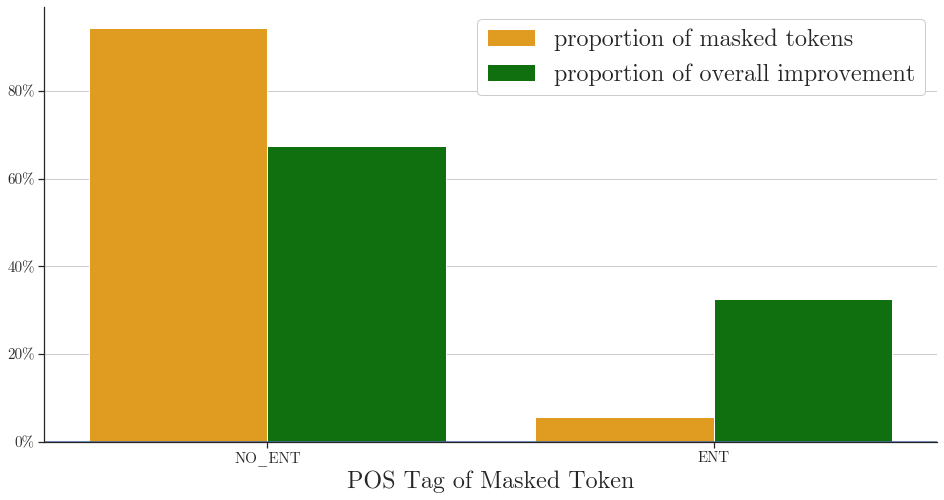

In [84]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False


calc_df["prop_token"] = calc_df.iloc[:,0]/calc_df.iloc[:,0].sum()
calc_df["prop_improvement"] = calc_df.iloc[:,1]/calc_df.iloc[:,1].sum()
tidy_df = calc_df[["prop_token", "prop_improvement"]].sort_values("prop_improvement", ascending=False).reset_index().melt(id_vars="masked_token_ner_binary").rename(columns=str.title)

fig, ax = plt.subplots(figsize=(16, 8))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))

# create seaborn plot
colors = ["orange", "green"]
ax=sns.barplot(x='Masked_Token_Ner_Binary', y='Value', hue='Variable', data=tidy_df, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='POS Tag of Masked Token', ylabel='')

# configure legend
legend = ax.legend(framealpha=1,  prop={'size': 24})
legend.get_texts()[0].set_text("proportion of masked tokens")
legend.get_texts()[1].set_text("proportion of overall improvement")

# set font sizes
ax.xaxis.label.set_size(24)
ax.tick_params(axis='x',labelsize= 15)
ax.tick_params(axis='y',labelsize= 15)

sns.despine(fig)

ax.axhline()

plt.show()

## Perplexity Changes by Test Set Document

### Load Labelled Test Sets

In [96]:
%%time

labelled_test_sets_dict = {}

directory = '../../0_data/clean/labelled_reddit/month_splits'
for filename in sorted(os.listdir(directory)):
    if filename.endswith("_5k.csv") and filename.startswith("test_"):
        labelled_test_sets_dict[filename.rstrip(".csv")] = pd.read_csv(os.path.join(directory, filename))

CPU times: user 495 ms, sys: 146 ms, total: 641 ms
Wall time: 746 ms


### Calculate Document-Level Changes in CE Loss from MLM and Write to CSV

In [133]:
%%time

for testset in full_df_dict:
    out_df = full_df_dict[testset][["case_id", "ce_base", "ce_rand_1m", "ce_match_1m"]].copy()
    
    # calculate improvements of domain and temporal adaptation
    out_df["ce_diff_base_rand"] = out_df.ce_base - out_df.ce_rand_1m
    out_df["ce_diff_rand_match"] = out_df.ce_rand_1m - out_df.ce_match_1m
    
    # calculate sum of ce loss difference per case (some cases will be NaN if no token in them was masked)
    merge_df = pd.DataFrame(out_df.groupby("case_id").ce_diff_rand_match.sum()).merge(out_df.groupby("case_id").ce_diff_base_rand.sum(), left_index=True, right_index=True)
    
    # load labelled test set, shuffle with seed 123 to match case_id from unlabelled test sets
    test_df = labelled_test_sets_dict[testset].copy().reset_index().sample(frac=1, random_state=123).reset_index(drop=True)

    # merge with results
    out_df = test_df.merge(merge_df, left_index=True, right_index=True, how="left")
    
    # write to csv
    print(f"writing {testset} to csv")
    out_df.set_index("index").sort_index().to_csv(f"../../0_data/clean/labelled_reddit/error_analysis/{testset}.csv", index=False)

writing test_2017_03_5k to csv
writing test_2017_04_5k to csv
writing test_2017_05_5k to csv
writing test_2017_06_5k to csv
writing test_2017_07_5k to csv
writing test_2017_08_5k to csv
writing test_2017_09_5k to csv
writing test_2017_10_5k to csv
writing test_2017_11_5k to csv
writing test_2017_12_5k to csv
writing test_2018_01_5k to csv
writing test_2018_02_5k to csv
writing test_2018_03_5k to csv
writing test_2018_04_5k to csv
writing test_2018_05_5k to csv
writing test_2018_06_5k to csv
writing test_2018_07_5k to csv
writing test_2018_08_5k to csv
writing test_2018_09_5k to csv
writing test_2018_10_5k to csv
writing test_2018_11_5k to csv
writing test_2018_12_5k to csv
writing test_2019_01_5k to csv
writing test_2019_02_5k to csv
writing test_2019_03_5k to csv
writing test_2019_04_5k to csv
writing test_2019_05_5k to csv
writing test_2019_06_5k to csv
writing test_2019_07_5k to csv
writing test_2019_08_5k to csv
writing test_2019_09_5k to csv
writing test_2019_10_5k to csv
writing 

***

# ADDITIONAL ANALYSES

## Makeup of Test Sets

### Split: POS, spaCy --> BERT

In [207]:
def count_tokens(input_series):
    count_tokens_dict = {}
    for entry in input_series:
        for elem in entry:
            if elem[1] not in count_tokens_dict:
                count_tokens_dict[elem[1]]= 1
            else:
                count_tokens_dict[elem[1]] += 1
                
    if "SPECIAL" in count_tokens_dict:
        del count_tokens_dict["SPECIAL"]
        
    return count_tokens_dict
    

for test_set in test_set_dict:
    
    print(test_set)
    
    count_dict = {}
    
    for column in ["text_pos", "tokens_pos"]:
        count_dict[column] = count_tokens(test_set_dict[test_set][column])
     
    plot_df = pd.DataFrame.from_dict(count_dict)
    plot_df = plot_df.sort_values(plot_df.columns[0], ascending=False)
    plot_df["ratio_bert_vs_spacy"] = plot_df.iloc[:,1]/plot_df.iloc[:,0]
    
    display(plot_df.style.background_gradient(cmap=cm, axis = 0, subset=plot_df.columns[2]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

test_2017_08_5k


,text_pos,tokens_pos,ratio_bert_vs_spacy
NOUN,35237,36604,1.04
VERB,28009,27429,0.98
PUNCT,25622,23727,0.93
PRON,18941,17334,0.92
DET,18363,16503,0.90
ADP,17034,15226,0.89
ADJ,13948,14068,1.01
ADV,12038,11343,0.94
AUX,11731,11569,0.99
PROPN,8128,9967,1.23


test_2018_08_5k


,text_pos,tokens_pos,ratio_bert_vs_spacy
NOUN,31798,33372,1.05
VERB,25675,25709,1.00
PUNCT,22127,21379,0.97
PRON,17335,15935,0.92
DET,16357,14856,0.91
ADP,15125,13723,0.91
ADJ,12651,13060,1.03
ADV,10774,10302,0.96
AUX,10355,10251,0.99
PROPN,6834,8336,1.22


test_2019_08_5k


,text_pos,tokens_pos,ratio_bert_vs_spacy
NOUN,30506,32721,1.07
VERB,24027,24480,1.02
PUNCT,21344,20508,0.96
PRON,16194,15074,0.93
DET,15379,14193,0.92
ADP,14138,13032,0.92
ADJ,12143,12657,1.04
ADV,10373,10063,0.97
AUX,9551,9594,1.00
PROPN,6512,8020,1.23


### Split: POS, spaCy --> BERT

In [209]:
def count_ent_tokens_binary(input_series):
    count_tokens_dict = {}
    count_tokens_dict["ENT"] = 0
    count_tokens_dict["NO_ENT"] = 0
    
    for entry in input_series:
        for elem in entry:
            if elem[1] == "SPECIAL":
                continue
            elif elem[1] == "NO_ENT":
                count_tokens_dict[elem[1]]+=1
            else:
                count_tokens_dict["ENT"]+=1

    return count_tokens_dict
    

for test_set in test_set_dict:
    
    print(test_set)
    
    count_dict = {}
    
    for column in ["text_ner", "tokens_ner"]:
        count_dict[column] = count_ent_tokens_binary(test_set_dict[test_set][column])
     
    plot_df = pd.DataFrame.from_dict(count_dict)
    plot_df = plot_df.sort_values(plot_df.columns[0], ascending=False)
    plot_df["ratio_bert_vs_spacy"] = plot_df.iloc[:,1]/plot_df.iloc[:,0]
    
    display(plot_df.style.background_gradient(cmap=cm, axis = 0, subset=plot_df.columns[2]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

test_2017_08_5k


,text_ner,tokens_ner,ratio_bert_vs_spacy
NO_ENT,198545,190739,0.96
ENT,10181,11264,1.11


test_2018_08_5k


,text_ner,tokens_ner,ratio_bert_vs_spacy
NO_ENT,177404,173298,0.98
ENT,8630,9639,1.12


test_2019_08_5k


,text_ner,tokens_ner,ratio_bert_vs_spacy
NO_ENT,168198,166588,0.99
ENT,8588,9551,1.11


***

## Makeup of Masked Tokens

### Number and Proportion of Masked Tokens by POS Tag

In [ ]:
for test_set in full_df_dict:
    
    print(test_set.upper(),"\n")
    
    n_tokens_total = full_df_dict[test_set].masked_token_pos.count()
    
    for pos_tag in full_df_dict[test_set].groupby("masked_token_pos").masked_token_pos.count().sort_values(ascending=False).index:
        
        n_tokens_pos = full_df_dict[test_set][full_df_dict[test_set].masked_token_pos==pos_tag].shape[0]
        
        print(pos_tag, "\t",
              n_tokens_pos, "\t",
              "({:.2%})".format(n_tokens_pos/n_tokens_total))

    print("\n")

### Number and Proportion of Masked Tokens by NER Tag

In [78]:
for test_set in full_df_dict:
    
    print(test_set.upper(),"\n")
    
    n_tokens_total = full_df_dict[test_set].masked_token_ner.count()
    
    for ner_tag in full_df_dict[test_set].groupby("masked_token_ner").masked_token_ner.count().sort_values(ascending=False).index:
        
        n_tokens_ner = full_df_dict[test_set][full_df_dict[test_set].masked_token_ner==ner_tag].shape[0]
        
        print(f"{ner_tag:>{12}}",
              f"{n_tokens_ner:>{10}}",
              "({:.2%})".format(n_tokens_ner/n_tokens_total))

    print("\n")

TEST_2017_08_5K 

      NO_ENT      21383 (94.10%)
      PERSON        321 (1.41%)
         ORG        304 (1.34%)
        DATE        174 (0.77%)
         GPE        135 (0.59%)
        NORP        116 (0.51%)
    CARDINAL         97 (0.43%)
     PERCENT         42 (0.18%)
 WORK_OF_ART         40 (0.18%)
     ORDINAL         23 (0.10%)
       MONEY         20 (0.09%)
         LOC         19 (0.08%)
        TIME         18 (0.08%)
       EVENT         10 (0.04%)
         FAC          6 (0.03%)
         LAW          5 (0.02%)
     PRODUCT          5 (0.02%)
    QUANTITY          5 (0.02%)


TEST_2018_08_5K 

      NO_ENT      19999 (94.56%)
      PERSON        254 (1.20%)
         ORG        234 (1.11%)
        DATE        133 (0.63%)
         GPE        133 (0.63%)
        NORP        120 (0.57%)
    CARDINAL        111 (0.52%)
     PERCENT         35 (0.17%)
 WORK_OF_ART         28 (0.13%)
       MONEY         19 (0.09%)
     ORDINAL         17 (0.08%)
        TIME         17 (0.08%)


***

## OVERALL CE LOSS

### Average CE loss by model

In [94]:
# average ce loss for base model, rand-adapted model and match-adapted model
for test_set in full_df_dict:
    print(test_set.upper())
    print("base:\t\t", full_df_dict[test_set].ce_base.mean())
    print("rand_1m:\t", full_df_dict[test_set].ce_rand_1m.mean())
    print("match:\t\t", full_df_dict[test_set]["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].mean())
    print()

TEST_2017_08_5K
base:		 2.99362104102905
rand_1m:	 2.135195438354173
match:		 2.120696549609558

TEST_2018_08_5K
base:		 3.206900931229308
rand_1m:	 2.196489964952725
match:		 2.1905164911946784

TEST_2019_08_5K
base:		 3.299640204861605
rand_1m:	 2.1827672095021664
match:		 2.172676544861859



***

## CE LOSS BY POS TAG

### Average CE loss by POS tag by model

In [98]:
# average ce loss by POS tag for base model, rand-adapted model and match-adapted model

cm = sns.color_palette('Reds', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_pos").tokens_pos.count()).merge(full_df_dict[test_set].groupby("masked_token_pos").ce_base.mean(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos").ce_rand_1m.mean(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].mean(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_pos", ascending=False)
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

TEST_2017_08_5K 



,tokens_pos,ce_base,ce_rand_1m,ce_2017_08_1m
masked_token_pos,,,,
NOUN,4164,4.50,3.23,3.20
VERB,3103,3.59,2.63,2.62
PUNCT,2684,1.45,0.84,0.84
PRON,1983,1.78,1.25,1.24
DET,1885,1.56,1.20,1.18
ADP,1681,1.85,1.35,1.35
ADJ,1568,4.66,3.55,3.57
AUX,1331,1.58,0.98,0.96
ADV,1240,3.87,2.86,2.86


TEST_2018_08_5K 



,tokens_pos,ce_base,ce_rand_1m,ce_2018_08_1m
masked_token_pos,,,,
NOUN,3923,4.67,3.39,3.37
VERB,2986,3.97,2.64,2.63
PUNCT,2513,1.86,0.88,0.90
PRON,1894,1.91,1.28,1.29
DET,1680,1.66,1.25,1.24
ADP,1509,1.88,1.36,1.35
ADJ,1494,4.52,3.36,3.37
ADV,1211,3.75,2.79,2.78
AUX,1147,1.88,0.89,0.89


TEST_2019_08_5K 



,tokens_pos,ce_base,ce_rand_1m,ce_2019_08_1m
masked_token_pos,,,,
NOUN,3800,4.70,3.25,3.24
VERB,2903,4.13,2.66,2.65
PUNCT,2373,2.30,0.96,0.97
PRON,1740,2.07,1.42,1.43
DET,1641,1.62,1.23,1.23
ADJ,1525,4.22,3.16,3.12
ADP,1478,1.98,1.43,1.42
ADV,1161,3.99,2.96,2.96
AUX,1148,1.89,0.84,0.84


### BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

In [126]:
# BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_pos").tokens_pos.count()).merge(full_df_dict[test_set].groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].sum(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_pos", ascending=False)
    
    calc_df["diff_base_rand_sum"] = calc_df.iloc[:,1]-calc_df.iloc[:,2]
    calc_df["diff_base_rand_mean"] = calc_df["diff_base_rand_sum"]/calc_df["tokens_pos"]
    calc_df["diff_base_rand_pct"] = (calc_df.iloc[:,1]-calc_df.iloc[:,2])/calc_df.iloc[:,1]
    calc_df = calc_df[["tokens_pos", "diff_base_rand_sum", "diff_base_rand_mean", "diff_base_rand_pct"]]
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

TEST_2017_08_5K 



,tokens_pos,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_pos,,,,
NOUN,4164,5311.39,1.28,0.28
VERB,3103,2968.97,0.96,0.27
PUNCT,2684,1643.80,0.61,0.42
PRON,1983,1051.88,0.53,0.30
DET,1885,683.75,0.36,0.23
ADP,1681,848.90,0.50,0.27
ADJ,1568,1744.07,1.11,0.24
AUX,1331,792.48,0.60,0.38
ADV,1240,1254.77,1.01,0.26


TEST_2018_08_5K 



,tokens_pos,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_pos,,,,
NOUN,3923,5017.25,1.28,0.27
VERB,2986,3964.80,1.33,0.33
PUNCT,2513,2455.62,0.98,0.52
PRON,1894,1194.84,0.63,0.33
DET,1680,683.73,0.41,0.25
ADP,1509,776.85,0.51,0.27
ADJ,1494,1730.36,1.16,0.26
ADV,1211,1166.23,0.96,0.26
AUX,1147,1141.83,1.00,0.53


TEST_2019_08_5K 



,tokens_pos,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_pos,,,,
NOUN,3800,5522.94,1.45,0.31
VERB,2903,4275.16,1.47,0.36
PUNCT,2373,3187.70,1.34,0.58
PRON,1740,1120.19,0.64,0.31
DET,1641,635.88,0.39,0.24
ADJ,1525,1613.04,1.06,0.25
ADP,1478,813.12,0.55,0.28
ADV,1161,1193.97,1.03,0.26
AUX,1148,1199.27,1.04,0.55


### RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

In [127]:
# RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_pos").tokens_pos.count()).merge(full_df_dict[test_set].groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_pos")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].sum(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_pos", ascending=False)
    
    calc_df["diff_rand_match_sum"] = calc_df.iloc[:,2]-calc_df.iloc[:,3]
    calc_df["diff_rand_match_mean"] = calc_df["diff_rand_match_sum"]/calc_df["tokens_pos"]
    calc_df["diff_rand_match_pct"] = (calc_df.iloc[:,2]-calc_df.iloc[:,3])/calc_df.iloc[:,2]
    calc_df = calc_df[["tokens_pos", "diff_rand_match_sum", "diff_rand_match_mean", "diff_rand_match_pct"]]
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

TEST_2017_08_5K 



,tokens_pos,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_pos,,,,
NOUN,4164,128.85,0.03,0.01
VERB,3103,31.10,0.01,0.00
PUNCT,2684,2.23,0.00,0.00
PRON,1983,20.48,0.01,0.01
DET,1885,39.04,0.02,0.02
ADP,1681,-4.49,-0.00,-0.00
ADJ,1568,-32.97,-0.02,-0.01
AUX,1331,34.04,0.03,0.03
ADV,1240,-5.34,-0.00,-0.00


TEST_2018_08_5K 



,tokens_pos,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_pos,,,,
NOUN,3923,85.28,0.02,0.01
VERB,2986,20.48,0.01,0.00
PUNCT,2513,-27.91,-0.01,-0.01
PRON,1894,-20.90,-0.01,-0.01
DET,1680,15.00,0.01,0.01
ADP,1509,14.80,0.01,0.01
ADJ,1494,-6.56,-0.00,-0.00
ADV,1211,3.64,0.00,0.00
AUX,1147,-9.42,-0.01,-0.01


TEST_2019_08_5K 



,tokens_pos,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_pos,,,,
NOUN,3800,38.16,0.01,0.00
VERB,2903,20.33,0.01,0.00
PUNCT,2373,-23.22,-0.01,-0.01
PRON,1740,-7.18,-0.00,-0.00
DET,1641,10.57,0.01,0.01
ADJ,1525,56.66,0.04,0.01
ADP,1478,4.26,0.00,0.00
ADV,1161,-1.28,-0.00,-0.00
AUX,1148,-0.80,-0.00,-0.00


### POS with largest improvements through DOMAIN adaptation

In [177]:
POS_TAG = "PROPN"

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    calc_df = full_df_dict[test_set].copy()
    
    calc_df["ce_reduction"] = calc_df.ce_base - calc_df.ce_rand_1m
    
    calc_df = calc_df.sort_values("ce_reduction")
    
    calc_df = calc_df[calc_df.masked_token_pos==POS_TAG]
    
    pd.set_option('display.max_colwidth', None)
    display(calc_df[["masked_token_text", "top_pred_token_text", "ce_reduction", "text"]].head(10))
    pd.reset_option('display.max_colwidth')

TEST_2017_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
17412,unite,unite,-10.754162,"The state (VA) could have prevented what happened. Spencer and the people at the ""Unite the Right"" rally had a permit to speak and assemble. The government took it away and then the ACLU actually defended Spencer and got them to give it back. Then the coward mayor reneged on it and issued a stand-down order *and* - before the violence even started at all - a state of emergency, just because the speakers who were there constitutionally were about to speak."
2510,help,help,-10.095800,HELPPPP HELPPPPPPPPPPPPP HELPPP HELPPP HELPPP FUCK FUCK IT'S BURNING GIMMME MILK GIMME MILK MEDIC!!! MEDIC!!! MEDIC!!! CRYING ON THE FLOOR FOR HELP SCREAMS LIKE A LITTLE BITCH WAT THE FUCK HAHAHAHAHAHAHAHAHAHAHAHAHHHHHHHHHHHHHHH
9396,florence,florence,-9.457678,"Nah, he'll be in Florence Supermax, which is effectively solitary confinement for the rest of his life."
15710,hay,hay,-8.192191,Hayek. Keynesianism is antithetical to conservatism.
22126,ian,ian,-6.090357,Things this drawing possesses that Ian does not: * A jaw * An actual haircut Things Ian possesses that the drawing does not: * 150 pounds * Thousands of ants
5915,libby,mueller,-6.037580,"This is what people need to understand, Special Prosecutors *will* send someone to jail for *something*. Libby took the hit on the Plame BS even though she was outed by the Clinton. Anyone who thinks Mueller was going to ever declare there is nothing there to prosecute *someone* is just deluding themselves. He is Ahab and the Trump administration is his white whale."
7962,cowboys,bernie,-5.733876,"You got it! We're the *Bernie Supporters* of the NFL; ***""So you're sayin' there's still a chance?!""*** btw - you'd be surprised how many Cowboys supporters there are in Houston, aka; *""Traitorous Fair-Weather Assclowns.""*"
8827,friedman,",",-5.603454,"I just watched a good talk on this, Milton Friedman 10 min long. [[URL] Tl;dw if immigrants were starving and not bettering themselves why did they come in droves, why did they keep sending back for there families. Now my own tid bit about poor conditions and anti trust. For one these were new industries, it's easy to look back and see obvious rules and regulations. But they had to learn on the go. By the time uncle Sam stepped in, companies and unions were already solving problems. Same deal with anti trust, the main company they looked to break up was standard oil. But if you looked at its market share the free market was already at work and it didn't command as dominating a market share as years before they finally broke it up. Speaking of free market have you read what the robber barons did to amass their wealth? They heavily innovated the production of their products. Rockefeller and his steal, and standard oil and oil. Standard oil got its mar"
11240,##e,buren,-4.677657,Are you stupid enough to think that LWoE doesn't support self-defense or what?
1343,rodney,##redo,-4.545736,"Nah, it started waaay, waaay before that. Remember the 1992 LA Rodney King Riots? Or Serpico who was left for dead in a drug bust for snitching on his corrupt colleagues? Or FBI's COINTELPRO that targeted Civil Rights Movement leaders? Add to the fact that there is a near-fanatical worship of the righteous of the police, it becomes almost impossible to enact reforms without being seen as being ""weak on crime""."


TEST_2018_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
21072,sinclair,sinclair,-7.286044,The true sign of having lost a debate is when they start picking apart your grammar or spelling. SINCLAIR 1 - INTOTHEIRISHOLE 0
3747,##bib,',-6.098368,"That is why I used to term relative. Habib_Marwuana was suggesting that deficit reduction is true tax cuts, and Obama did reduce the deficit. My opinion is that tax cuts are tax cuts, and Trump for all his ills did give us a tax cut."
12502,fran,",",-5.758948,"A minimum wage worker in the US ($15,000/yr) has more purchasing power than 93% of the people on the planet. www.globalrichlist.com Maybe housing costs are higher in NYC/San Fran etc. but on average, this holds. There is a reason people risk their lives and freedom fro the privilege of cleaning our toilets."
16474,sarah,mike,-5.117484,Never put two and two together. Go figure. Mike Huckabee and Sarah Sanders are related....
3,king,he,-5.103664,"One of his opponents does. Angus King is the incumbent centrist lib Independent Senator, and will likely cruise to reelection. The Democrat is [extremely good]([URL] however."
6006,honduras,it,-5.079516,"Don't forget Honduras Seriously though, this woman is toxic fucking waste, and the Dems just keep running back to her."
2,angus,he,-4.916455,"One of his opponents does. Angus King is the incumbent centrist lib Independent Senator, and will likely cruise to reelection. The Democrat is [extremely good]([URL] however."
16019,##ter,##sily,-4.513964,"Vater Willhelm will cane our rumps, rendered joyously plump by overconsumption of chocolate bestowed by our doting Bavarian mutter, for this trespass"
17447,commodore,ho,-3.921198,"Meanwhile, a self taught engineer like Bill Herd, who designed the Commodore 128, wouldn't be able to even get an interview today. Back in his day, he was able to learn from engineers and develop entire systems. That guy would be stuck in Geek Squad today while an H1B gets six figures to do nothing. It's amazing to me how many people working in STEM can't even hook up a TV, have zero interest in computers off the clock and cannot self teach any new skills. But, listen to the blue hairs in the HR department, can't have geeks in the IT department, need more H1B and diversity hires."
7172,blunt,thomas,-3.776780,I wish I could vote for Ted. Sadly I have Roy Blunt and Claire McCaskill.


TEST_2019_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
8339,hasan,he,-10.991942,Hasan was born in New Jersey. I get being offended by his disgusting comments but this argument that if you don’t agree with me you aren’t a real American is anti free speech and a form of McCarthyism.
9803,alexander,like,-9.092610,Looks more Alexander McQueen to me.
8920,joe,##eral,-9.052445,"I tried to make it not just a typical Chud but I tried to add some shitlib Joe Biden support at the end, to emphasize that the policies of Joe Biden basically imply believing something like what I wrote and to emphasize that neoliberals are so elitist when they claim to hate Nazis but support unlimited global capitalism, make fun of ""rednecks"" for being ""trashy and poor (and racist, secondarily)"", and talk about how ORANGE MAN DRUMPF is evidence of ""idiocracy"" without realizing the fascistic implications of even TALKING about ""Idiocracy"", AKA eugenics. To think ""idiocracy"" is a legitimate problem, and that (combined with the EVIL RUSSIANS #commietrump) caused Trump to win the election and not more fundamental systemic factors, is to basically go full elitist-mode and support pro-natalling the population up, if the shitlibs were logically consistent. Which they're not, but it's kind of making fun of how shitlibs will endorse Alt-Right talking points (like Eugenics) or Boomer neoconservative talking points (lik"
12079,guy,guy,-7.521257,"There needs to be a Chapo only about The Boys. It’s 90s style Boondock Saints, early Guy Ritchie with some Wanted, illiterate Watchmen, with Trump shit thrown in. It’s so incredibly bad and yet it’s impossible to turn away from. Karl Urban doing Norman Reedus and his fucking jackets haha"
4685,friedman,he,-7.408559,Why has the deep red state of Alaska have UBI for over 40 years? Because they haven't. They have a small dividend that's been shown to reduce the number of hours worked. >It's supported by Milton Friedman. Nope. Friedman supported a NIT for those already no welfare. Not a UBI for everyone in the country.
15255,friedman,friedman,-6.717285,"You need a robust business environment to siphon off. Period. Sweden has complete school choice, with 80% private schools, on the voucher system proposed by Milton Friedman. They also have 2/3 private roads."
533,dracula,dracula,-6.182727,"Oh no, I'm sure Dracula in Auschwitz is acting in good faith."
13518,effort,effort,-6.016296,"Mods, why isnt this tagged Effort Post?"
1307,ned,ned,-5.996786,Ned Flanders?
6790,kennedy,cruz,-4.940476,"Romney ran as a ""liberal"" against Ted Kennedy in 1994. Biden have never pretended that he isn't center-right."


### POS with largest improvements through TEMPORAL adaptation

In [174]:
POS_TAG = "NOUN"

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    calc_df = full_df_dict[test_set].copy()
    
    calc_df["ce_reduction"] = calc_df.ce_rand_1m - calc_df["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))]
    
    calc_df = calc_df.sort_values("ce_reduction")
    
    calc_df = calc_df[calc_df.masked_token_pos==POS_TAG]
    
    pd.set_option('display.max_colwidth', None)
    display(calc_df[["masked_token_text", "top_pred_token_text", "ce_reduction", "text"]].head(10))
    pd.reset_option('display.max_colwidth')

TEST_2017_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
1938,cha,hip,-6.156935,"Mike, go on chapo"
8597,gang,age,-5.505152,"They did this during the primaries. Apparently immigration wasn't a thing until Trump made it a topic... As in Cruz who single handedly ended the gang of 8 amnesty bill and had been proposing a border wall security years before Trump even mentioned the ideas wasn't ""on top of the issues"". It was absolutely infuriating. A lot of them probably never tuned into politics until the GOP primaries."
17502,##fi,##fi,-5.058303,got a bitcoin says they all pedofiles
6801,action,",",-4.924623,[Quite]([URL] [the]([URL] [opposite]([URL] [actually]([URL] [Even back in the day]([URL] and modern-day pop culture gets in on the action.
21720,##es,##ley,-4.857106,Hello Nunes. See ya soon.
13309,ball,out,-4.339029,"Bush didn't fuck up Katrina. Typically disasters are handled first and foremost by the local government and state governments of an area. The federal government, even under Bush, acts as support and goes where needed. FEMA was not prepared for a state completely being incompetent and dropping the ball. Bush made sure after that event that it would be ready for such incompetence. Katrina was a monumental fuck up by the Mayor of New Orleans as well as the Governor of the state. They did everything wrong and then shifted the blame to Bush; as in he was supposed to be micromanaging their state and their response. The Democratic Mayor of Houston I'm told made the same mistake of telling the citizens not to evacuate (even though Abott told them to). Any loss of life will be his fault."
10585,hat,went,-4.259261,where the MAGA hat for the blond one ?
334,##ors,##sion,-4.148287,"""High Crimes and Misdemenors"" is not a criminal statute. The congress defines, by definition, what those are at the time of impeachment. I'd say they would use precedent, but we don't have much to go on at this point (and the precedent we DO have isn't favorable to trump)"
17909,capital,fir,-3.937534,"If I owned a large farm that was larger than other peoples but I farmed it all myself, can I keep it? I need to know if you are one of the cancerous leftists based on jealousy or if you are only a leftist because you are against capital accumulation giving some people way too much power."
1631,&,?,-3.669036,"What was the Scott Foval Quote? Oh yes: ""We have mentally ill people that we pay to do shit, make no mistake."" www.youtube.com/watch?v=5IuJGHuIkzY&feature=youtu.be&t=1m26s"


TEST_2018_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
1988,guns,ago,-6.443506,"I didn't even notice that the girl in the photo is that woman who got thrown in a US concentration camp for the crime of liking guns while being Russian. Sick shit. You're no neocon, since at least the neocons weren't on par with nazis."
7088,du,com,-4.060313,"I would take Trumps half-hearted see through non-sense, any day over Obamas straight up duplicity with the American people."
1299,cheek,way,-3.701769,'turning the other cheek' turns into 'spreading our ass' very quickly...that kind of thinking is why we had the bushes presidencies and the rapist and obongo as our presidents.
21002,fa,po,-3.203963,"I don't see this OP as praising him. I think it's more a case of ""even this Nazi dipshit is using better rhetoric in his self-serving fash-y argument than the Democrats are""."
1909,##ds,##mps,-3.176866,"If these kids are in college and really believe this Peterson shit is some ""unmeditated truth"" while their professors hide the secrets, they're just fuckin dumb. All these chuds going to class thinking their Youtube bullshit counts for an education. Just read a god damn journal article written by an academic in their field of expertise. The left is afraid of Jordan Peterson because we recognize reactionary fuck sticks riling up dumb-ass dudes that think their intellectuals cause they heard a guy misquote a misquote of a rambling aside Nietzsche made once when he was taking a shit."
1349,crime,census,-3.131340,"Averages are misleading. The entire US violent crime data set is heavily skewed by a few really bad neighborhoods in Chicago, LA etc. These outliers are so violent and gang ridden that when you exclude them the entire rest of the country compares well with other first world countries for things like handgun homicide. When you take them alone, they compare to failed states. Ideally I'd have something better than an average, but this is the best I have in terms of data. That said, worth noting that the stats of immigrants could just as easily be skewed if we really were seeing the numbers of ""toxic masculinity"" flowing across the border that OP suggests. > In the end though citizens of a country have a right to decide, via their government's policy, how many people may come in and from where. Illegal immigrants are here in violation of that right, and that alone is sufficient that they should be deported. I agree--but we don't have to continue pushing the narrative that these immigrants are largely v"
20763,irony,thing,-3.007602,The best irony about that is people don't see that when talking about Kennedy who was Bork's replacement nomination.
9030,fly,left,-2.862079,"Flyover states like Alabama, Mississippi? You want to see some clueless white people with regards to black people? Talk to the far leftists at Berkeley. [How white liberals really view black voters]([URL]"
6213,box,completion,-2.859927,Or got her grade from other activities. Shes dumb as a box of rocks.
8207,pill,light,-2.846704,Nature is trying to give you a red pill!


TEST_2019_08_5K 



,masked_token_text,top_pred_token_text,ce_reduction,text
7474,life,rest,-5.005116,"Good man. I voted for Swain! We need to do something about all this leftist crap that keeps growing here. Memphis is lost (I can’t for the life of me understand how the skullet chicken eater rules that roost). Cooper is not as bad, but he’s pretty damn awful. His brother is in the run-off for mayor & all I can think is political dynasty (e.g. Bush, Clinton, Pelosi’s family/Newsom). I’m praying for Chattanooga. If they blue our 3 main cities, they’re in."
4,##mas,##ove,-4.652072,"2026, the year of the democratic Chinese revolution, lead by a broke, starving people who want the same living qualities of Hong Kong and Taiwan, sweeps the nation, ending the mass gulags of 2025 that popped up enmasse as the Chinese economy collapsed."
4674,##cha,##me,-4.623391,"Oh jeez, its almost like forcing people off public discussion through absurd, extreme censorship only creates spiteful echochambers."
15320,likes,well,-4.431452,"This is so bad I could only stand about a minute of it. It’s amazing how they are still on the air. How do they just keep getting worse and worse? This is straight up garbage! I see it’s got twice as many dislikes as likes, so there’s that."
13858,##ju,##version,-4.319265,"Well, there's the signed affidavit from the woman who claims she was raped by Trump when she was 13/14. This is also corroborated by another woman. Both through signed affidavits with the penalty of being charged with perjury if untrue. The incident was allegedly arranged through Jeffrey Epstein, the pedophile buddy of Donald Trump."
11645,defect,protest,-4.004884,Does Cuba take defectors? Asking for a friend
3195,##zie,picture,-3.905907,"guys, i think we've got our fonzie!"
4098,min,minimum,-3.805592,first and formost find out the reason why people think its ok to shoot other people. why is it that violent responses are acceptable or viewed as the only way to get attention? Healthcare is a great option and raise the min wage so that people and eat sleep and relax but also breed compation so that the jobs who get fucked by the min wage increase also get raises. education education education. teach ALL of our students right from wrong as well as teach them how to be adults in highschool. that includes budgeting taxes and preparing them for a world that as of right now is something they are not prepared for. Teach open mindedness. your not always right and neither is the other person. being able to talk and discuss things without getting mad or doing baseless accusations is a great way to let people know that they are not ignored. Have the media be unbiased. report stories as they happened with a consistent formula and after ensuring that they happened the way they did. right now the media judges people
9983,forefront,door,-3.793120,"Best part is, if roles were reversed and Hannity were the one who went all roid rage lunatic, Fredo would be at the forefront of getting Hannity fired."
8207,tax,logical,-3.635067,If there was no tax deduction do you think we'd see a sharp decline in philanthropy?


***

## CE LOSS BY NER TAG

### Average CE loss by NER tag by model

In [122]:
# average ce loss by NER tag for base model, rand-adapted model and match-adapted model

cm = sns.color_palette('Reds', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_ner_binary").tokens_ner.count()).merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_base.mean(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_rand_1m.mean(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].mean(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_ner", ascending=False)
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

TEST_2017_08_5K 



,tokens_ner,ce_base,ce_rand_1m,ce_2017_08_1m
masked_token_ner_binary,,,,
NO_ENT,21383,2.90,2.08,2.06
ENT,1340,4.50,3.08,3.01


TEST_2018_08_5K 



,tokens_ner,ce_base,ce_rand_1m,ce_2018_08_1m
masked_token_ner_binary,,,,
NO_ENT,19999,3.10,2.11,2.11
ENT,1151,5.07,3.61,3.58


TEST_2019_08_5K 



,tokens_ner,ce_base,ce_rand_1m,ce_2019_08_1m
masked_token_ner_binary,,,,
NO_ENT,19410,3.21,2.11,2.11
ENT,1125,4.79,3.39,3.32


### BASE VS RAND: Improvement in sum of CE and avg. CE loss by NER tag

In [128]:
# BASE VS RAND: Improvement in sum of CE and avg. CE loss by NER tag

cm = sns.color_palette('Greens', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_ner_binary").tokens_ner.count()).merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_base.sum(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_rand_1m.sum(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].sum(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_ner", ascending=False)
    
    calc_df["diff_base_rand_sum"] = calc_df.iloc[:,1]-calc_df.iloc[:,2]
    calc_df["diff_base_rand_mean"] = calc_df["diff_base_rand_sum"]/calc_df["tokens_ner"]
    calc_df["diff_base_rand_pct"] = (calc_df.iloc[:,1]-calc_df.iloc[:,2])/calc_df.iloc[:,1]
    calc_df = calc_df[["tokens_ner", "diff_base_rand_sum", "diff_base_rand_mean", "diff_base_rand_pct"]]
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

TEST_2017_08_5K 



,tokens_ner,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_ner_binary,,,,
NO_ENT,21383,17604.61,0.82,0.28
ENT,1340,1901.40,1.42,0.32


TEST_2018_08_5K 



,tokens_ner,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_ner_binary,,,,
NO_ENT,19999,19699.23,0.99,0.32
ENT,1151,1670.96,1.45,0.29


TEST_2019_08_5K 



,tokens_ner,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_ner_binary,,,,
NO_ENT,19410,21358.16,1.10,0.34
ENT,1125,1576.83,1.40,0.29


### RAND VS MATCH: Improvement in sum of CE and avg. CE loss by NER tag

In [130]:
# RAND VS MATCH: Improvement in sum of CE and avg. CE loss by NER tag

cm = sns.color_palette('Greens', as_cmap=True)

for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    # first column is number of tokens by POS tag
    calc_df = pd.DataFrame(full_df_dict[test_set].groupby("masked_token_ner_binary").tokens_ner.count()).merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_base.sum(), left_index=True, right_index=True)
    
    # merge rand adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary").ce_rand_1m.sum(), left_index=True, right_index=True)
    
    # merge match adapted model
    calc_df = calc_df.merge(full_df_dict[test_set].groupby("masked_token_ner_binary")["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))].sum(),
                          left_index=True, right_index=True)

    calc_df = calc_df.sort_values("tokens_ner", ascending=False)
    
    calc_df["diff_rand_match_sum"] = calc_df.iloc[:,2]-calc_df.iloc[:,3]
    calc_df["diff_rand_match_mean"] = calc_df["diff_rand_match_sum"]/calc_df["tokens_ner"]
    calc_df["diff_rand_match_pct"] = (calc_df.iloc[:,2]-calc_df.iloc[:,3])/calc_df.iloc[:,2]
    calc_df = calc_df[["tokens_ner", "diff_rand_match_sum", "diff_rand_match_mean", "diff_rand_match_pct"]]
    
    display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(4))

TEST_2017_08_5K 



,tokens_ner,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_ner_binary,,,,
NO_ENT,21383,238.8254,0.0112,0.0054
ENT,1340,90.6328,0.0676,0.0219


TEST_2018_08_5K 



,tokens_ner,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_ner_binary,,,,
NO_ENT,19999,91.5628,0.0046,0.0022
ENT,1151,34.7762,0.0302,0.0084


TEST_2019_08_5K 



,tokens_ner,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_ner_binary,,,,
NO_ENT,19410,127.5100,0.0066,0.0031
ENT,1125,79.7018,0.0708,0.0209


### ENT with largest improvements through DOMAIN adaptation

In [179]:
for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    calc_df = full_df_dict[test_set].copy()
    
    calc_df["ce_reduction"] = calc_df.ce_base - calc_df.ce_rand_1m
    
    calc_df = calc_df.sort_values("ce_reduction")
    
    calc_df = calc_df[calc_df.masked_token_ner_binary=="ENT"]
    
    pd.set_option('display.max_colwidth', None)
    display(calc_df[["masked_token_text", "masked_token_ner", "top_pred_token_text", "ce_reduction", "text"]].head(10))
    pd.reset_option('display.max_colwidth')

TEST_2017_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
2510,help,ORG,help,-10.095800,HELPPPP HELPPPPPPPPPPPPP HELPPP HELPPP HELPPP FUCK FUCK IT'S BURNING GIMMME MILK GIMME MILK MEDIC!!! MEDIC!!! MEDIC!!! CRYING ON THE FLOOR FOR HELP SCREAMS LIKE A LITTLE BITCH WAT THE FUCK HAHAHAHAHAHAHAHAHAHAHAHAHHHHHHHHHHHHHHH
9396,florence,ORG,florence,-9.457678,"Nah, he'll be in Florence Supermax, which is effectively solitary confinement for the rest of his life."
22126,ian,ORG,ian,-6.090357,Things this drawing possesses that Ian does not: * A jaw * An actual haircut Things Ian possesses that the drawing does not: * 150 pounds * Thousands of ants
5915,libby,PERSON,mueller,-6.037580,"This is what people need to understand, Special Prosecutors *will* send someone to jail for *something*. Libby took the hit on the Plame BS even though she was outed by the Clinton. Anyone who thinks Mueller was going to ever declare there is nothing there to prosecute *someone* is just deluding themselves. He is Ahab and the Trump administration is his white whale."
7962,cowboys,ORG,bernie,-5.733876,"You got it! We're the *Bernie Supporters* of the NFL; ***""So you're sayin' there's still a chance?!""*** btw - you'd be surprised how many Cowboys supporters there are in Houston, aka; *""Traitorous Fair-Weather Assclowns.""*"
8827,friedman,PERSON,",",-5.603454,"I just watched a good talk on this, Milton Friedman 10 min long. [[URL] Tl;dw if immigrants were starving and not bettering themselves why did they come in droves, why did they keep sending back for there families. Now my own tid bit about poor conditions and anti trust. For one these were new industries, it's easy to look back and see obvious rules and regulations. But they had to learn on the go. By the time uncle Sam stepped in, companies and unions were already solving problems. Same deal with anti trust, the main company they looked to break up was standard oil. But if you looked at its market share the free market was already at work and it didn't command as dominating a market share as years before they finally broke it up. Speaking of free market have you read what the robber barons did to amass their wealth? They heavily innovated the production of their products. Rockefeller and his steal, and standard oil and oil. Standard oil got its mar"
11240,##e,GPE,buren,-4.677657,Are you stupid enough to think that LWoE doesn't support self-defense or what?
1343,rodney,EVENT,##redo,-4.545736,"Nah, it started waaay, waaay before that. Remember the 1992 LA Rodney King Riots? Or Serpico who was left for dead in a drug bust for snitching on his corrupt colleagues? Or FBI's COINTELPRO that targeted Civil Rights Movement leaders? Add to the fact that there is a near-fanatical worship of the righteous of the police, it becomes almost impossible to enact reforms without being seen as being ""weak on crime""."
2396,1980s,DATE,a,-4.289305,"Trump is extremely moderate and little more than a 1990s Democrat in many ways, so obviously the left would prefer Pence, who is a more 1980s Republican. Not that the left gets the make this choice mind you, it's not their decision, Americans voted for Trump and will continue to do so."
4927,mets,ORG,big,-4.050227,"You're a Mets fan, does anyone outside of Queens even root for them? It must kill you that this Indian loser is banging your idea of Aryan perfection. Tough luck you tubby nazi fuck."


TEST_2018_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
12502,fran,FAC,",",-5.758948,"A minimum wage worker in the US ($15,000/yr) has more purchasing power than 93% of the people on the planet. www.globalrichlist.com Maybe housing costs are higher in NYC/San Fran etc. but on average, this holds. There is a reason people risk their lives and freedom fro the privilege of cleaning our toilets."
3453,4,CARDINAL,34,-5.558755,"Hold on the line after the one highlighted mentions that 34h is half a day more than 30.4h, now I’m going to assume they mean “woking day” rather than that they think 4 is half of 24. Still rather misleading right? I mean a quick read might lead someone to assume they are pending a whole extra 1/14 of the time working rather than 1/50"
14821,',WORK_OF_ART,',-5.383242,"""’He's now president for life. President for life. And he’s great. And look, he was able to do that. I think it’s great. Maybe we’ll give that a shot some day"". Worked for Julius Caesar. About to have his government immunity expire, and be open to a lot of lawsuits from an angry senate, BOOM invades and is made dictator for life."
16474,sarah,PERSON,mike,-5.117484,Never put two and two together. Go figure. Mike Huckabee and Sarah Sanders are related....
6006,honduras,PERSON,it,-5.079516,"Don't forget Honduras Seriously though, this woman is toxic fucking waste, and the Dems just keep running back to her."
16019,##ter,PERSON,##sily,-4.513964,"Vater Willhelm will cane our rumps, rendered joyously plump by overconsumption of chocolate bestowed by our doting Bavarian mutter, for this trespass"
17447,commodore,GPE,ho,-3.921198,"Meanwhile, a self taught engineer like Bill Herd, who designed the Commodore 128, wouldn't be able to even get an interview today. Back in his day, he was able to learn from engineers and develop entire systems. That guy would be stuck in Geek Squad today while an H1B gets six figures to do nothing. It's amazing to me how many people working in STEM can't even hook up a TV, have zero interest in computers off the clock and cannot self teach any new skills. But, listen to the blue hairs in the HR department, can't have geeks in the IT department, need more H1B and diversity hires."
7172,blunt,PERSON,thomas,-3.776780,I wish I could vote for Ted. Sadly I have Roy Blunt and Claire McCaskill.
805,spence,PERSON,elect,-3.501431,Do you want President Spence? Because this is how you get President Spence.
1161,bryan,PERSON,me,-3.428584,Re-name it “Murder-Pain-Land” in honor of Brett and Bryan.


TEST_2019_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
8339,hasan,PERSON,he,-10.991942,Hasan was born in New Jersey. I get being offended by his disgusting comments but this argument that if you don’t agree with me you aren’t a real American is anti free speech and a form of McCarthyism.
9803,alexander,PERSON,like,-9.092610,Looks more Alexander McQueen to me.
8920,joe,PERSON,##eral,-9.052445,"I tried to make it not just a typical Chud but I tried to add some shitlib Joe Biden support at the end, to emphasize that the policies of Joe Biden basically imply believing something like what I wrote and to emphasize that neoliberals are so elitist when they claim to hate Nazis but support unlimited global capitalism, make fun of ""rednecks"" for being ""trashy and poor (and racist, secondarily)"", and talk about how ORANGE MAN DRUMPF is evidence of ""idiocracy"" without realizing the fascistic implications of even TALKING about ""Idiocracy"", AKA eugenics. To think ""idiocracy"" is a legitimate problem, and that (combined with the EVIL RUSSIANS #commietrump) caused Trump to win the election and not more fundamental systemic factors, is to basically go full elitist-mode and support pro-natalling the population up, if the shitlibs were logically consistent. Which they're not, but it's kind of making fun of how shitlibs will endorse Alt-Right talking points (like Eugenics) or Boomer neoconservative talking points (lik"
12079,guy,PERSON,guy,-7.521257,"There needs to be a Chapo only about The Boys. It’s 90s style Boondock Saints, early Guy Ritchie with some Wanted, illiterate Watchmen, with Trump shit thrown in. It’s so incredibly bad and yet it’s impossible to turn away from. Karl Urban doing Norman Reedus and his fucking jackets haha"
4685,friedman,ORG,he,-7.408559,Why has the deep red state of Alaska have UBI for over 40 years? Because they haven't. They have a small dividend that's been shown to reduce the number of hours worked. >It's supported by Milton Friedman. Nope. Friedman supported a NIT for those already no welfare. Not a UBI for everyone in the country.
15255,friedman,PERSON,friedman,-6.717285,"You need a robust business environment to siphon off. Period. Sweden has complete school choice, with 80% private schools, on the voucher system proposed by Milton Friedman. They also have 2/3 private roads."
533,dracula,PERSON,dracula,-6.182727,"Oh no, I'm sure Dracula in Auschwitz is acting in good faith."
13518,effort,ORG,effort,-6.016296,"Mods, why isnt this tagged Effort Post?"
1307,ned,PERSON,ned,-5.996786,Ned Flanders?
6790,kennedy,PERSON,cruz,-4.940476,"Romney ran as a ""liberal"" against Ted Kennedy in 1994. Biden have never pretended that he isn't center-right."


### ENT with largest improvements through TEMPORAL adaptation

In [180]:
for test_set in full_df_dict:
    
    print(test_set.upper(), "\n")
    
    calc_df = full_df_dict[test_set].copy()
    
    calc_df["ce_reduction"] = calc_df.ce_rand_1m - calc_df["ce_{}_1m".format(re.search("test_(.*?)_5k",test_set).group(1))]
    
    calc_df = calc_df.sort_values("ce_reduction")
    
    calc_df = calc_df[calc_df.masked_token_ner_binary=="ENT"]
    
    pd.set_option('display.max_colwidth', None)
    display(calc_df[["masked_token_text", "masked_token_ner", "top_pred_token_text", "ce_reduction", "text"]].head(10))
    pd.reset_option('display.max_colwidth')

TEST_2017_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
11804,cha,GPE,hip,-5.727687,Basically the left just needs to do better if we want more Chapo.
17111,epstein,PERSON,##s,-5.679600,Google Jeffrey Epstein. [Down the rabbit hole you go]([URL]
3342,rand,PERSON,john,-5.352423,So does Rand Paul for voting for Sessions. You'll find more sympathy for that notion here than you'd think lol. At least I hope you would.
15050,cha,PERSON,hip,-5.096961,Yes! If Chapo started a YouTube channel I would double my patreon contribution instantly.
10746,ea,ORG,ea,-4.828532,_What's the difference between EA and North Korea?_ _North Korea didn't fuck up as many launches as EA._
12284,epa,ORG,wall,-4.732260,You are arguing with a wall. The EPA is Nixon's greatest achievement and singlehandedly has done more good for the environment than any corporation or business that has ever existed on the face of this earth.
12421,freedom,WORK_OF_ART,.,-4.624943,"Yeah, probably photo OP. Still, this guy is on top of our Gun Rights, and defending Religious Freedom No complaints here."
7025,mad,PERSON,christian,-4.382392,"Again, my issue is with Maduro and Cabello et al, not with the philosophy of Chavismo"
8598,8,CARDINAL,freedom,-4.193852,"They did this during the primaries. Apparently immigration wasn't a thing until Trump made it a topic... As in Cruz who single handedly ended the gang of 8 amnesty bill and had been proposing a border wall security years before Trump even mentioned the ideas wasn't ""on top of the issues"". It was absolutely infuriating. A lot of them probably never tuned into politics until the GOP primaries."
3302,david,PERSON,#,-3.809829,"""“You have not sufficiently demonstrated that the public’s interest in disclosure outweighs personal privacy interests of the subject,” FBI records management section chief David M. Hardy told Mr. Clevenger in a letter Monday."" >[URL] Please Sign the Petition. ******7:40 P.M. Pacific Standard Time, 19,000 - 20000 Signatures in 1+ day so far (number fluctuates due to the website algorithm collecting the signatures apparently), please also sign the other petition relevant to the topic if you can!****** [URL]"


TEST_2018_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
6580,romney,PERSON,-,-7.734925,Mitt Romney lookin ass
13532,lamar,PERSON,kendrick,-5.062409,Read this to Kendrick Lamar’s LUST.
13489,dave,PERSON,but,-4.812177,You are correct I too used to be guilty of calling anyone on the left a liberal. But a more correct term would be leftist. However “leftists” do have some pretty liberal policy ideas they are just very extreme. Dave Rubin is a fantastic example of a classical liberal.
8113,an,PERSON,end,-4.440935,"I'm an AnCap, bro. Don't go all ideological purity on me. That's boring."
13371,china,EVENT,lover,-3.771929,They (the cuntons) have been in bed with the Chicoms for over 25 years.. 1996 Chinagate ring any bells?
10092,##hof,PERSON,.,-3.642308,"I wish I had scum bags to vote out, but the senator up for reelection on my ballot is Bernie Sanders. You can't really get much further from the Trump cult. I like that I get to call him my senator, but sometimes I wish I had the chance to vote against someone Inhofe or McConnell. Having some ""at large"" seats in the legislature that get distributed based on the national popular vote would be nice, but it'd be a huge constitutional rework. (I'm talking about one of the more advanced voting systems that CGP Grey [covers later in his Elections of the Jungle Council series of videos]([URL]"
3996,beck,PERSON,##a,-3.557458,Because no one pays any attention to Glenn Beck. I’d suggest you do the same
6329,palm,GPE,colorado,-3.161307,"Agents, along with EMS professionals and fire department personnel, provided aid and assessed the man's injuries. The man suffered bilateral femur fractures to both legs and a possible back injury. The man was airlifted to a medical center in Palm Springs. Our tax dollars are already being spent on him. The helicopter should have air lifted him back over the wall and deposited him on the other side for his country to help him."
606,pad,GPE,brad,-2.857932,More like the Parkland kid. They were so ready to jump on that with the narrative. They knew beforehand. You didn’t hear much about gun control after Paddock which makes me think it’s something so ugly they just wanted it to go away.
8083,nike,ORG,him,-2.448938,"He will if no one rewards him via giving money to Nike and his shoes, via watching his movies he will release. They said the same thing about the nfl and they took a hit. Lebron needs to take a hit by all of us not giving him a dime via his products."


TEST_2019_08_5K 



,masked_token_text,masked_token_ner,top_pred_token_text,ce_reduction,text
533,dracula,PERSON,dracula,-10.240352,"Oh no, I'm sure Dracula in Auschwitz is acting in good faith."
8858,##tani,PERSON,##e,-5.200358,Thanks!... I'm a proud Kekistani that will be enlisting in the upcoming meme war!!!
795,bet,GPE,pac,-4.728546,"I donated to Bernie and got on his text list and his team posts the same stuff I got from Beto, which kinda sours it for me."
285,bet,GPE,kidd,-3.573647,"Give it up Beto, you never stood a chance."
13934,##pf,PERSON,##men,-3.344309,But...but...but...Der Drumpf commands it!
10687,3rd,ORDINAL,second,-3.208788,"I think he still has the tools to be a solid backup (3rd string worst case), but is it worth the side show that he brings? Is it worth the divide to the locker room he brings? Not a chance."
343,nz,GPE,this,-3.093046,"LOL you think someone like Kamala or bernie won't label us all crazy? Are you serious? After NZ they classified all ""white nationalists"" as terrorist and put them on watch lists. Btw, NZ is part of five eyes, so we are all probably being monitored already. Wake up."
17936,marx,PERSON,.,-2.976103,I’m gonna have to appropriate this sentence and start using the term Karl Marx objectivism
2299,3,CARDINAL,11th,-2.866379,"“Go to systems dot 3, 3, 0, 3, oh dot com”"
8056,1000,MONEY,[UNK],-2.703845,"Definitely a perspective I see a lot. To me there's two aspects. 1. Philosophically the point isn't for everyone to get $1000/mo more, it's for everyone to get $1000/mo minimum to make sure their basic needs are met. Theres no time investment required so the ""more"" is whatever people do with their time. 2. In practice a depressingly low percentage of people that need help are actually receiving it from the current programs we have. Universality ensures that we don't keep screwing up the way our safety net is designed."
